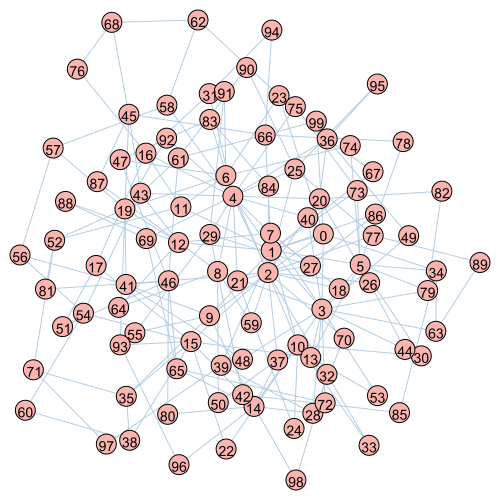

In [1]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
#G = Graph.Erdos_Renyi(n = 100, p = 0.1, directed = False)
G = Graph.Barabasi(n = 100, m = 2, directed = False)
#G = Graph.Tree(100,2)



G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})


# Plotting with custom colors and saving to a file
p_style = {"bbox": (500, 500), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
output_path = "C:/Users/abbau/Downloads/ER400.pdf"
# Specify the path and filename here
plot(G, target=output_path, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [2]:
# Parameters
# Transmission rate
beta = 0.5
# Recovery rate
gamma = 0.5
#Time 
T = 3
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 1

In [3]:
def calculate_gamma_power(node, graph, a, b=0.1):
    # Example: calculate gamma based on the degree of the node
    degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
    return a * (degree ** b) 

In [56]:
def SIR_PODMP(g, p0, beta, T, a):
    
    # Get initial infection probabilities for each node
    start, nodes, init_probs = time.time(), p0['node'].tolist(), p0['prob'].tolist()
    
    # Create a dictionary to store recovery rates for each node
    gamma_dict = {node: calculate_gamma_power(node, g, a) for node in nodes}

    # initialising marginals and messages
    mrg_s = np.zeros((T, len(nodes)))
    mrg_i = np.zeros((T, len(nodes)))
    mrg_r = np.zeros((T, len(nodes)))
    msg_phi = {}
    msg_theta = {}
    
    # Initialize message dictionaries for each edge
    for edge in g.itertuples(index=False):
        edge = tuple(sorted((edge.source, edge.target)))
        msg_phi[edge] = np.zeros(T)
        msg_phi[tuple(reversed(edge))] = np.zeros(T)

        msg_theta[edge] = np.ones(T)
        msg_theta[tuple(reversed(edge))] = np.ones(T)
    
    # Set initial Susceptible probabilities
    mrg_i[0, :] = np.array(init_probs)
    mrg_s[0, :] = 1.0 - np.array(init_probs)
    for k, v in msg_phi.items():
        v[0] = init_probs[k[0]]
        
        
    # Precompute neighbors
    neighbors = {i: set() for i in nodes}
    for edge in g.itertuples(index=False):
        source, target = edge.source, edge.target
        neighbors[source].add(target)
        neighbors[target].add(source) 

    
    # DMP
    for t in range(1,T):
        # Update theta values
        for e, v in msg_theta.items():
            v[t] = v[t-1] - beta * msg_phi[e][t-1]
        
        # Update susceptible
        for i in range(len(nodes)):
            # Start with previous time step's susceptible probability
            mrg_s[t, i] = 1.0 - init_probs[i]
            # Update based on neighbors
            for neighbor in neighbors[i]:
                mrg_s[t, i] *= msg_theta[(neighbor, i)][t]
                
        # Update phi     
        for e, w in msg_phi.items():
            w[t] = (1.0 - beta) * (1.0 - gamma_dict[e[0]]) * w[t-1]
            w[t] += mrg_s[t-1, e[0]] / msg_theta[e[::-1]][t-1]
            w[t] -= mrg_s[t, e[0]] / msg_theta[e[::-1]][t]
            w[t] = max(0, min(w[t], 1))
        
        # Update recovered
        for i in range(len(nodes)):
            mrg_r[t, i] = mrg_r[t-1, i] + gamma_dict[i] * (1.0 - mrg_s[t-1, i] - mrg_r[t-1, i])
           
        
        # Update infected
        for i in range(len(nodes)):
            mrg_i[t, i] = 1.0 - mrg_s[t, i] - mrg_r[t, i]
    print("PODMP Runtime:   " + str(round(time.time() - start, 2)) + " seconds")
    return mrg_s, mrg_i, mrg_r, msg_phi, msg_theta


def SIR_POENSEMBLE(g, p0, beta, T, a):
    # Get initial infection probabilities for each node
    start, nodes, init_probs = time.time(), p0['node'].tolist(), p0['prob'].tolist()
    
    # Create a dictionary to store recovery rates for each node
    gamma_dict = {node: calculate_gamma_power(node, g, a) for node in nodes}
    
    # Initialize probabilities for each state
    mrg_s = np.zeros((T, len(nodes)))
    mrg_i = np.zeros((T, len(nodes)))
    mrg_r = np.zeros((T, len(nodes)))

    # Set initial state probabilities
    mrg_i[0, :] = np.array(init_probs)
    mrg_s[0, :] = 1.0 - np.array(init_probs)

    # Precompute neighbors
    neighbors = {i: set() for i in nodes}
    for edge in g.itertuples(index=False):
        source, target = edge.source, edge.target
        neighbors[source].add(target)
        neighbors[target].add(source)

    # Master Equation Simulation
    for t in range(1, T):
        for i, node in enumerate(nodes):
            # Calculate the product term for the S and I updates
            product_term = np.prod([1 - beta * mrg_i[t - 1, nodes.index(neighbor)] for neighbor in neighbors[node]])

            # Update Susceptible (S)
            mrg_s[t, i] = mrg_s[t - 1, i] * product_term

            # Update Infected (I)
            mrg_i[t, i] = mrg_i[t - 1, i] + (1 - product_term) * mrg_s[t - 1, i] - gamma_dict[node] * mrg_i[t - 1, i]

            # Update Recovered (R)
            mrg_r[t, i] = mrg_r[t - 1, i] + gamma_dict[node] * mrg_i[t - 1, i]

        # Normalize the probabilities to sum to 1
        for i in range(len(nodes)):
            total = mrg_s[t, i] + mrg_i[t, i] + mrg_r[t, i]
            mrg_s[t, i] /= total
            mrg_i[t, i] /= total
            mrg_r[t, i] /= total
                        
    print("POENSEMBLE Runtime:   " + str(round(time.time() - start, 2)) + " seconds")
    return mrg_s, mrg_i, mrg_r

def SIR_POWMC(g, p0, beta, T, num_simulations, a):
    nodes = p0['node'].tolist()
    init_probs = p0['prob'].tolist()
    start = time.time()
    
    # Create a dictionary to store recovery rates for each node
    gamma_dict = {node: calculate_gamma_power(node, g, a) for node in nodes}

    # Extract nodes with a specific initial infection probability
    unique_prob = [prob for prob in set(init_probs) if prob != 0][0]
    initialized_nodes = p0[p0['prob'] == unique_prob]['node'].tolist()


    # Create neighbors dictionary
    neighbors = {node: set() for node in nodes}
    for row in g.itertuples():
        neighbors[row.source].add(row.target)
        neighbors[row.target].add(row.source)

    # Results arrays
    avg_mrg_s = np.zeros((T, len(nodes)))
    avg_mrg_i = np.zeros((T, len(nodes)))
    avg_mrg_r = np.zeros((T, len(nodes)))

    for simulation in range(num_simulations):
        # Initialize states as susceptible
        state = {node: 'S' for node in nodes}
        
        
        # Randomly infect other nodes based on probabilities
        for node, init_prob in zip(nodes, init_probs):
            if node in initialized_nodes and np.random.random() < init_prob:
                state[node] = 'I'

        # Count initial states before the simulation starts
        for i, node in enumerate(nodes):
            avg_mrg_s[0, i] += state[node] == 'S'
            avg_mrg_i[0, i] += state[node] == 'I'
            avg_mrg_r[0, i] += state[node] == 'R'

        # Simulation loop
        for t in range(1, T):
            new_state = state.copy()
            for i in nodes:
                if state[i] == 'I':
                    # Infect susceptible neighbors
                    for neighbor in neighbors[i]:
                        if state[neighbor] == 'S' and np.random.random() < beta:
                            new_state[neighbor] = 'I'
                    # Recovery
                    if np.random.random() < gamma_dict[i]:
                        new_state[i] = 'R'
            state = new_state

            # Count states at each time step
            for i, node in enumerate(nodes):
                avg_mrg_s[t, i] += state[node] == 'S'
                avg_mrg_i[t, i] += state[node] == 'I'
                avg_mrg_r[t, i] += state[node] == 'R'
                
            
                
    # Average the results across simulations
    avg_mrg_s /= num_simulations
    avg_mrg_i /= num_simulations
    avg_mrg_r /= num_simulations
    
   
    print("POMC Runtime:   " + str(round(time.time() - start, 2)) + " seconds")

    return avg_mrg_s, avg_mrg_i, avg_mrg_r

In [7]:
#predicted_s, predicted_i, predicted_r , p, t = SIR_PODMP(g, p0, beta, T)

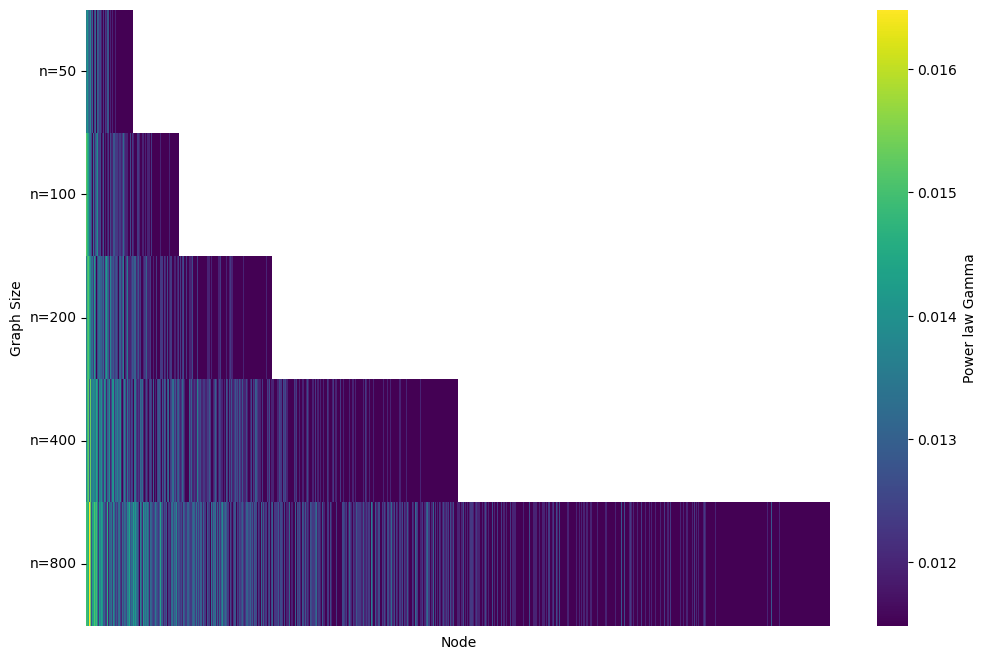

In [52]:
# # Load packages
# from igraph import *
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to calculate gamma power
# def calculate_gamma_power(node, graph, a, b=0.1):
#     degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
#     return a * (degree ** b)

# # Function to create graph and calculate gamma powers
# def create_graph_and_calculate_gamma(n, m=2, a=0.01, b=0.1):
#     G = Graph.Barabasi(n=n, m=m, directed=False)
#     G.vs["name"] = [str(i) for i in range(len(G.vs))]
#     g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
#                       'target': [x for e in G.es for x in (e.target, e.source)]})
#     gamma_powers = [calculate_gamma_power(node, g, a, b) for node in range(len(G.vs))]
#     return gamma_powers

# # Sizes of the graphs
# sizes = [50, 100, 200, 400, 800]

# # Initialize an empty list to store gamma power values
# gamma_matrix = []

# # Calculate gamma powers for each graph size and store in matrix
# for size in sizes:
#     gamma_powers = create_graph_and_calculate_gamma(size)
#     gamma_matrix.append(gamma_powers + [np.nan] * (max(sizes) - len(gamma_powers)))  # Pad with NaNs for equal length

# # Convert the list to a numpy array for heatmap plotting
# gamma_matrix = np.array(gamma_matrix)

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(gamma_matrix, cmap='viridis', cbar_kws={'label': 'Power law Gamma'}, xticklabels=False)

# plt.xlabel('Node')
# plt.ylabel('Graph Size')
# plt.yticks(ticks=np.arange(len(sizes)) + 0.5, labels=[f'n={size}' for size in sizes], rotation=0)
# plt.savefig('C:/Users/abbau/Downloads/power.pdf', format='pdf',bbox_inches="tight")
# plt.show()


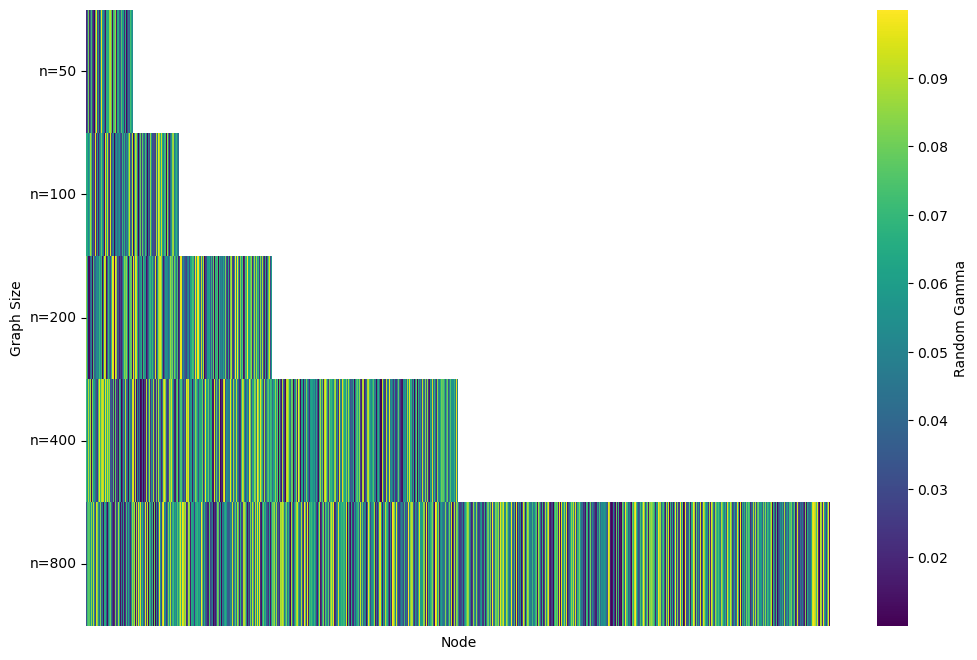

In [53]:
# import numpy as np
# import pandas as pd
# import random
# from igraph import Graph
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to calculate a random gamma value
# def calculate_gamma_random():
#     min_recovery_rate = 0.01  
#     max_recovery_rate = 0.1
#     return random.uniform(min_recovery_rate, max_recovery_rate)

# # Function to create graph and calculate gamma powers
# def create_graph_and_calculate_gamma(n, m=2):
#     G = Graph.Barabasi(n=n, m=m, directed=False)
#     G.vs["name"] = [str(i) for i in range(len(G.vs))]
#     gamma_powers = [calculate_gamma_random() for node in range(len(G.vs))]
#     return gamma_powers

# # Sizes of the graphs
# sizes = [50, 100, 200, 400, 800]

# # Initialize an empty list to store gamma power values
# gamma_matrix = []

# # Calculate gamma powers for each graph size and store in matrix
# for size in sizes:
#     gamma_powers = create_graph_and_calculate_gamma(size)
#     gamma_matrix.append(gamma_powers + [np.nan] * (max(sizes) - len(gamma_powers)))  # Pad with NaNs for equal length

# # Convert the list to a numpy array for heatmap plotting
# gamma_matrix = np.array(gamma_matrix)

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(gamma_matrix, cmap='viridis', cbar_kws={'label': 'Random Gamma'}, xticklabels=False)

# plt.xlabel('Node')
# plt.ylabel('Graph Size')
# plt.yticks(ticks=np.arange(len(sizes)) + 0.5, labels=[f'n={size}' for size in sizes], rotation=0)
# plt.savefig('C:/Users/abbau/Downloads/random.pdf', format='pdf',bbox_inches="tight")
# plt.show()


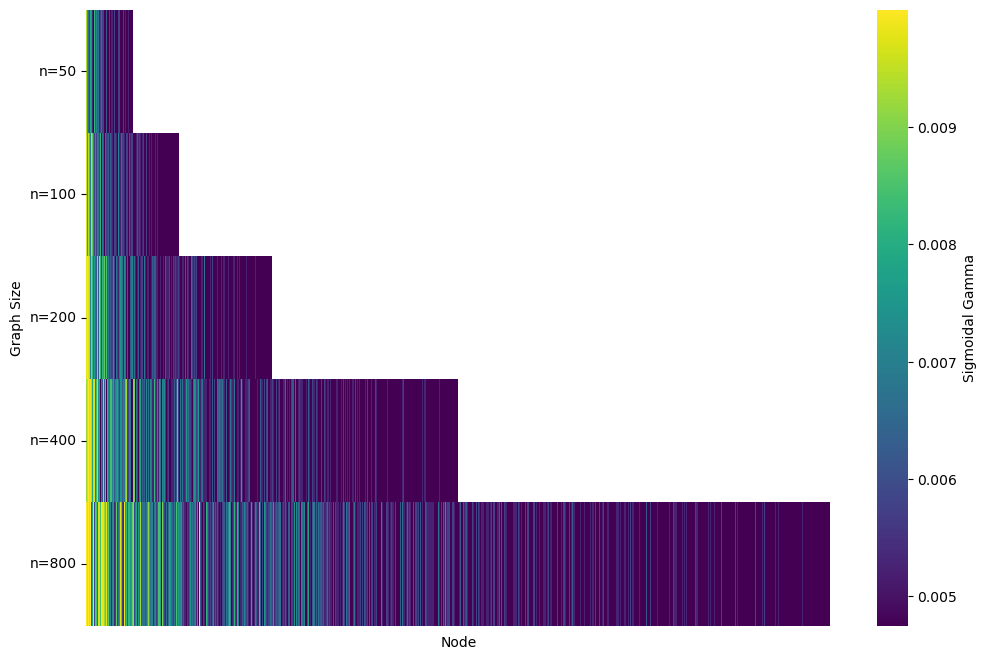

In [54]:
# import math
# def calculate_gamma_sigmoidal(node, graph, a=0.01, b=0.01, c=5):
#     degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
#     return a / (1 + math.exp(-b * (degree - c)))

# # Function to create graph and calculate gamma powers
# def create_graph_and_calculate_gamma(n, m=2, a=0.01, b=0.1):
#     G = Graph.Barabasi(n=n, m=m, directed=False)
#     G.vs["name"] = [str(i) for i in range(len(G.vs))]
#     g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
#                       'target': [x for e in G.es for x in (e.target, e.source)]})
#     gamma_powers = [calculate_gamma_sigmoidal(node, g, a, b) for node in range(len(G.vs))]
#     return gamma_powers

# # Sizes of the graphs
# sizes = [50, 100, 200, 400, 800]

# # Initialize an empty list to store gamma power values
# gamma_matrix = []

# # Calculate gamma powers for each graph size and store in matrix
# for size in sizes:
#     gamma_powers = create_graph_and_calculate_gamma(size)
#     gamma_matrix.append(gamma_powers + [np.nan] * (max(sizes) - len(gamma_powers)))  # Pad with NaNs for equal length

# # Convert the list to a numpy array for heatmap plotting
# gamma_matrix = np.array(gamma_matrix)

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(gamma_matrix, cmap='viridis', cbar_kws={'label': 'Sigmoidal Gamma'}, xticklabels=False)

# plt.xlabel('Node')
# plt.ylabel('Graph Size')
# plt.yticks(ticks=np.arange(len(sizes)) + 0.5, labels=[f'n={size}' for size in sizes], rotation=0)
# plt.savefig('C:/Users/abbau/Downloads/sigmoidal.pdf', format='pdf',bbox_inches="tight")
# plt.show()

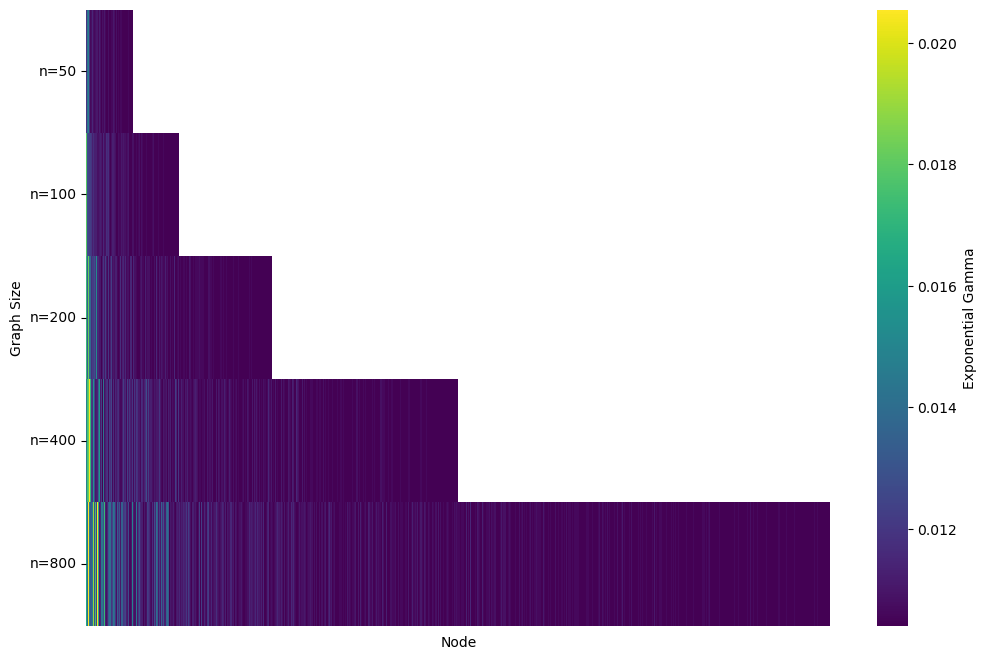

In [55]:
# import math
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from igraph import Graph

# # Function to calculate gamma exponential for a node in the graph
# def calculate_gamma_exponential(node, graph, a=0.01, b=0.01):
#     degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
#     return a * math.exp(b * degree)

# # Function to create a Barabási-Albert graph and calculate gamma powers for its nodes
# def create_graph_and_calculate_gamma(n, m=2, a=0.01, b=0.01):
#     G = Graph.Barabasi(n=n, m=m, directed=False)
#     G.vs["name"] = [str(i) for i in range(len(G.vs))]
#     g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
#                       'target': [x for e in G.es for x in (e.target, e.source)]})
#     gamma_powers = [calculate_gamma_exponential(node, g, a, b) for node in range(len(G.vs))]
#     return gamma_powers

# # Sizes of the graphs to generate
# sizes = [50, 100, 200, 400, 800]

# # Initialize an empty list to store gamma power values
# gamma_matrix = []

# # Calculate gamma powers for each graph size and store in the matrix
# for size in sizes:
#     gamma_powers = create_graph_and_calculate_gamma(size)
#     gamma_matrix.append(gamma_powers + [np.nan] * (max(sizes) - len(gamma_powers)))  # Pad with NaNs for equal length

# # Convert the list to a numpy array for heatmap plotting
# gamma_matrix = np.array(gamma_matrix)

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(gamma_matrix, cmap='viridis', cbar_kws={'label': 'Exponential Gamma'}, xticklabels=False)

# plt.xlabel('Node')
# plt.ylabel('Graph Size')
# plt.yticks(ticks=np.arange(len(sizes)) + 0.5, labels=[f'n={size}' for size in sizes], rotation=0)
# plt.savefig('C:/Users/abbau/Downloads/Exponential.pdf', format='pdf',bbox_inches="tight")
# plt.show()
